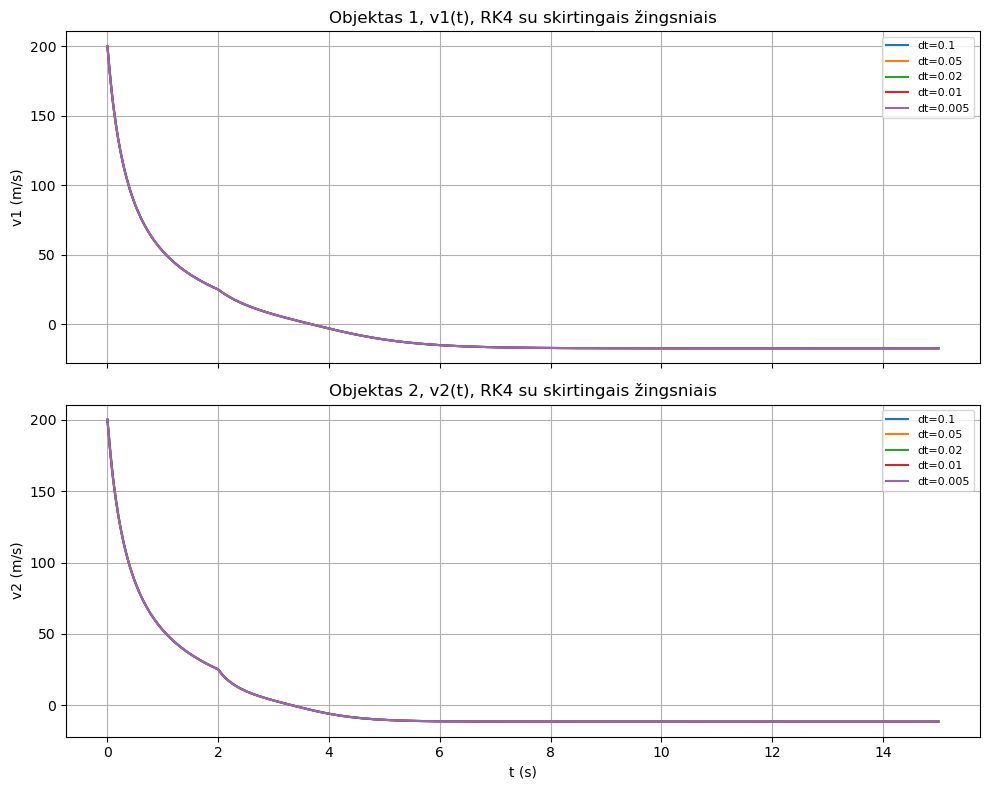

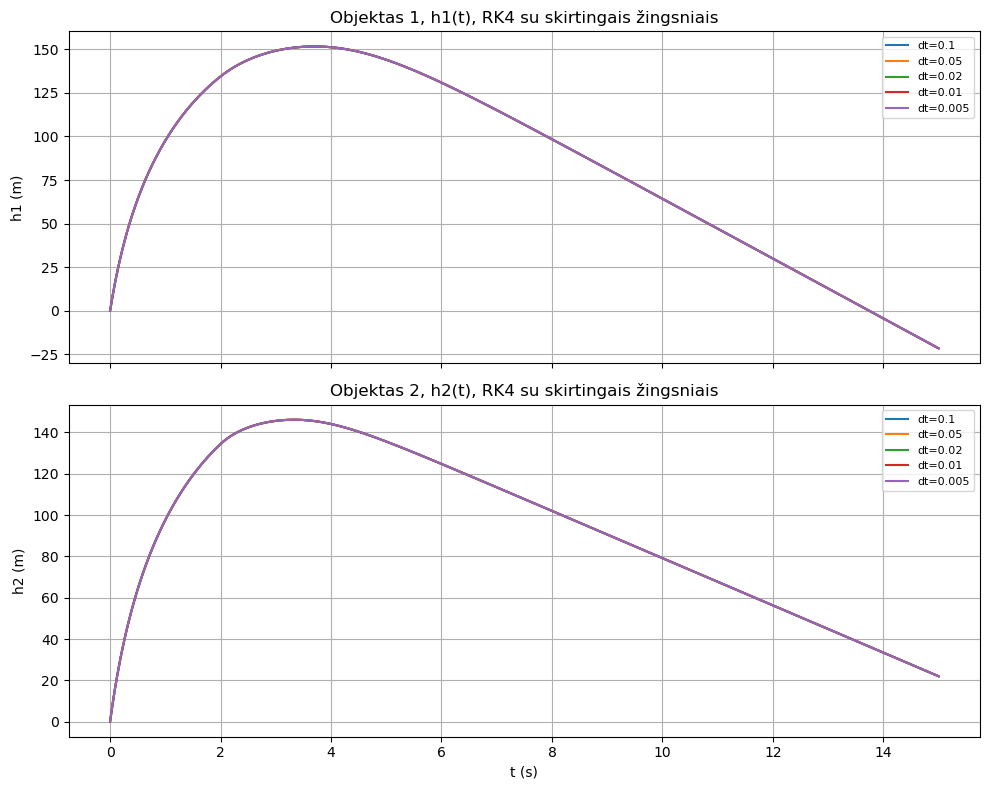

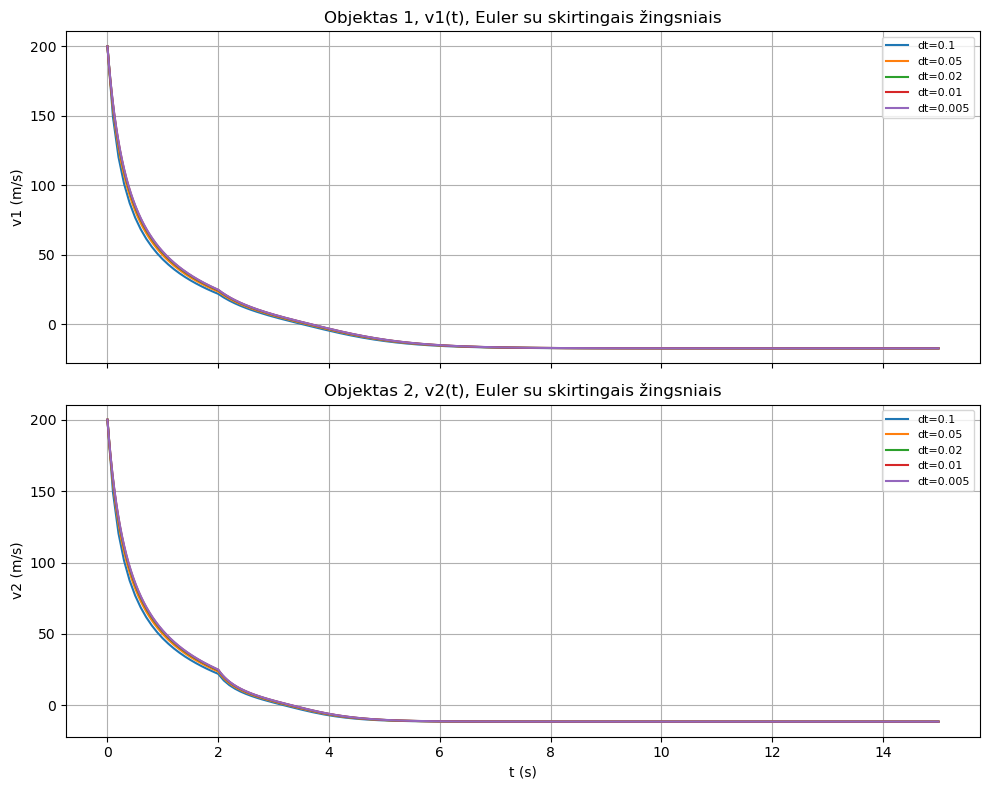

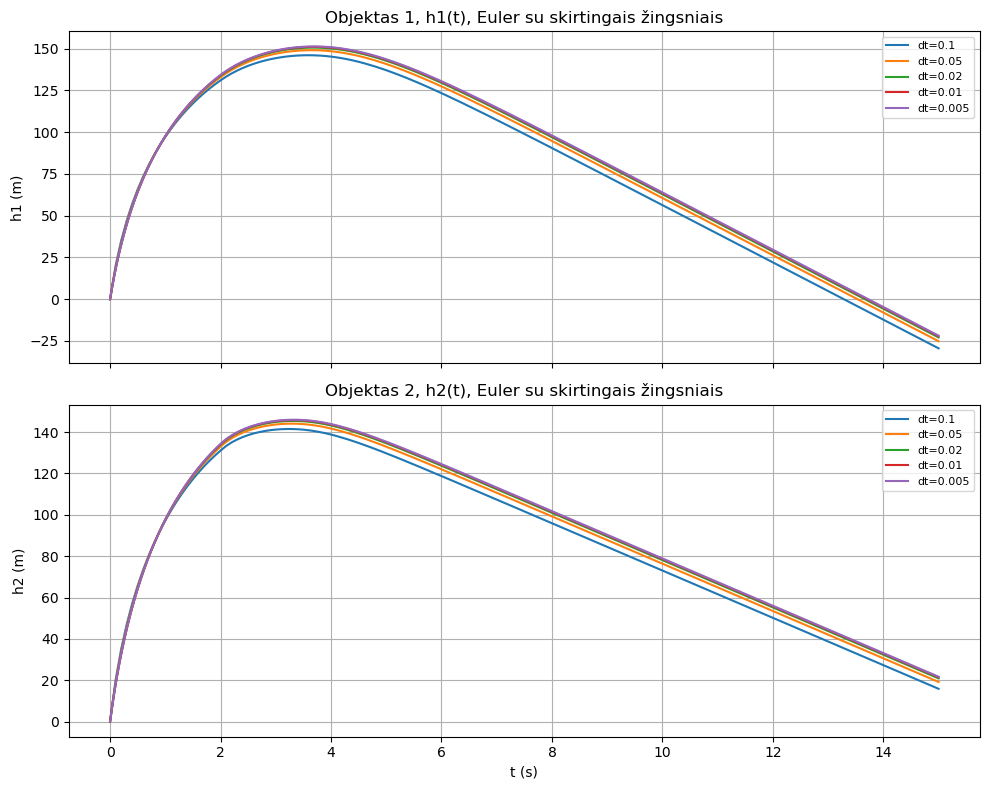

== Aukščiausi taškai (RK4, dt = 0.0050) ==
Objektas 1: t = 3.6996 s, h = 151.5982 m
Objektas 2: t = 3.3334 s, h = 146.1566 m

== Aukščiausi taškai (Euler, dt = 0.0050) ==
Objektas 1: t = 3.6919 s, h = 151.3679 m
Objektas 2: t = 3.3264 s, h = 145.9642 m


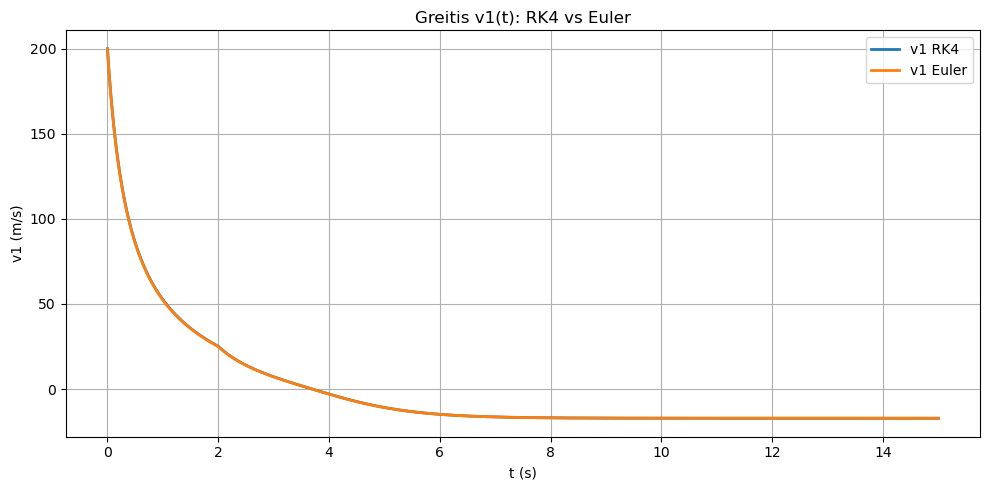

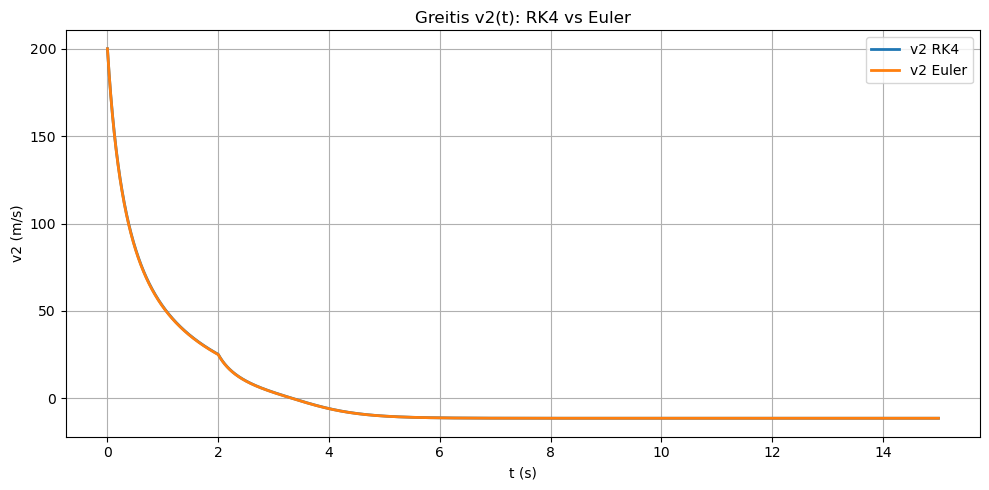

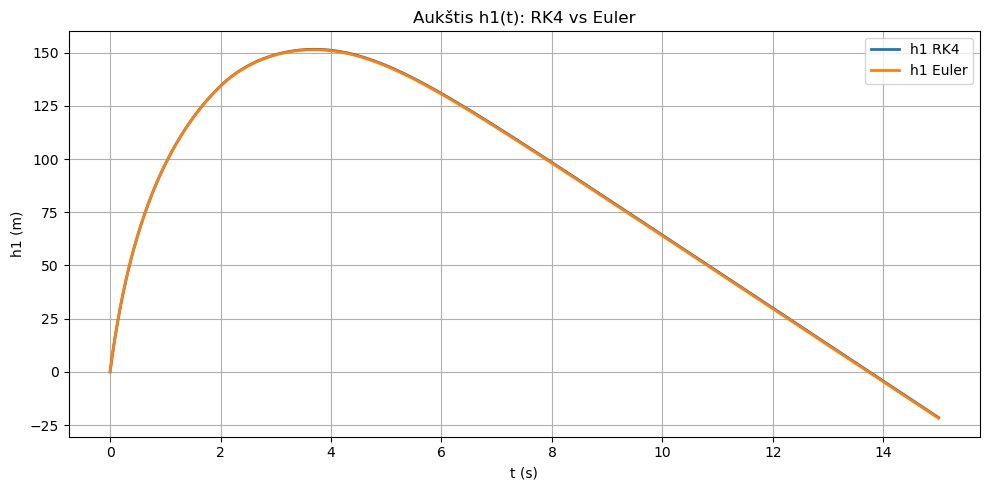

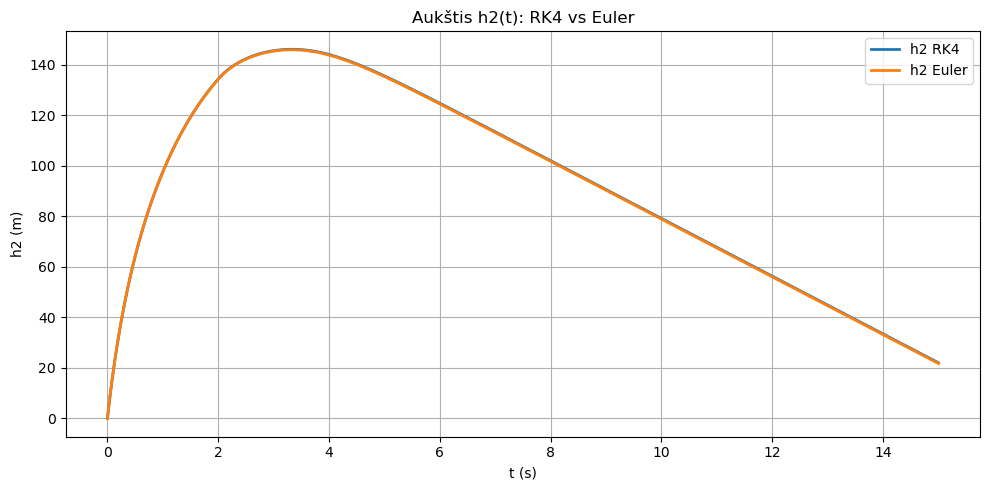


== Tikslumo palyginimas su solve_ivp (objektas 1, greitis v1) ==
      dt max|v_RK4-v_ivp| max|v_Eu-v_ivp|
  0.1000 2.2694e+00 1.1670e+01
  0.0500 6.6628e-01 5.1557e+00
  0.0200 1.1835e-01 1.9434e+00
  0.0100 3.0688e-02 9.5427e-01
  0.0050 7.8135e-03 4.7292e-01


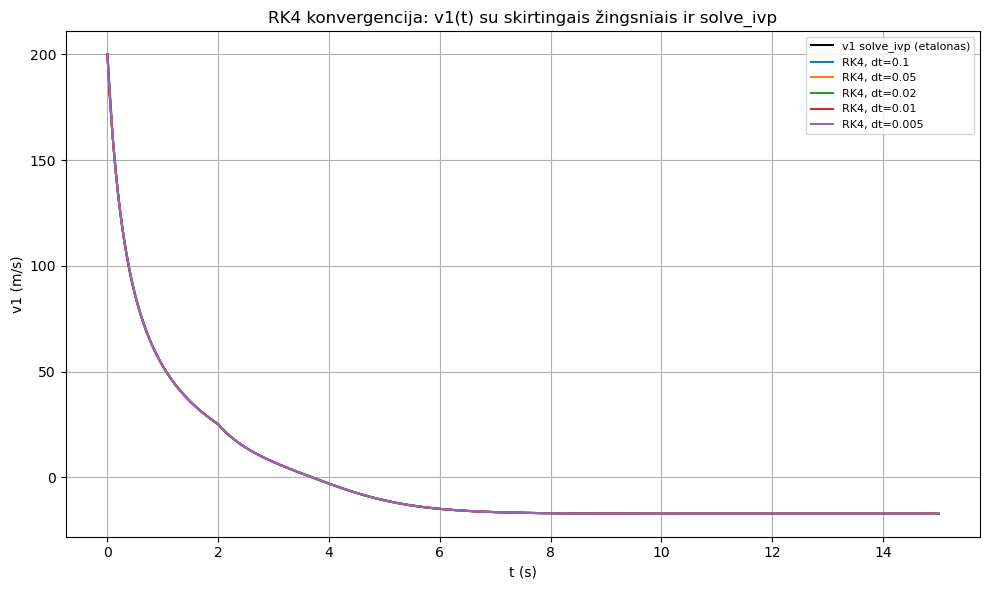

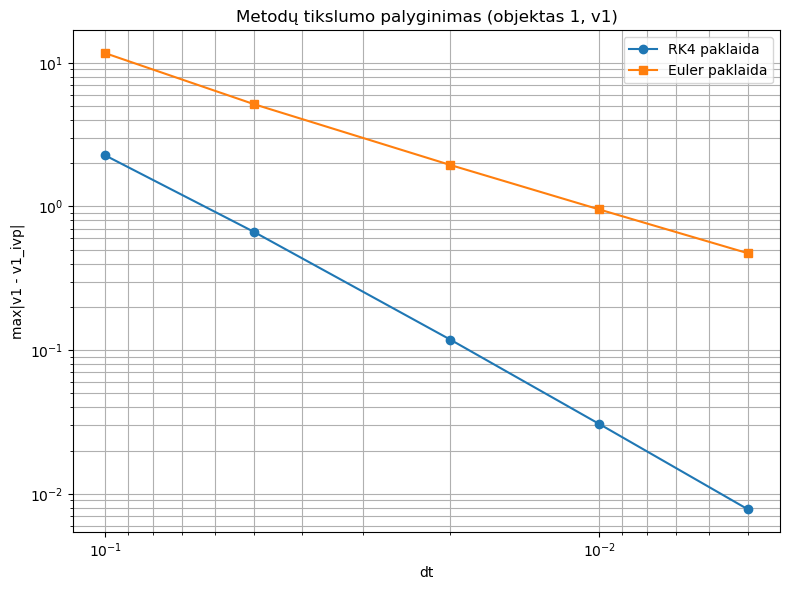


== Stabilumo tyrimas (heuristinis) ==
Euler metodas: didžiausias stabilus dt ≈ 0.6
RK4 metodas  : didžiausias stabilus dt ≈ 0.8


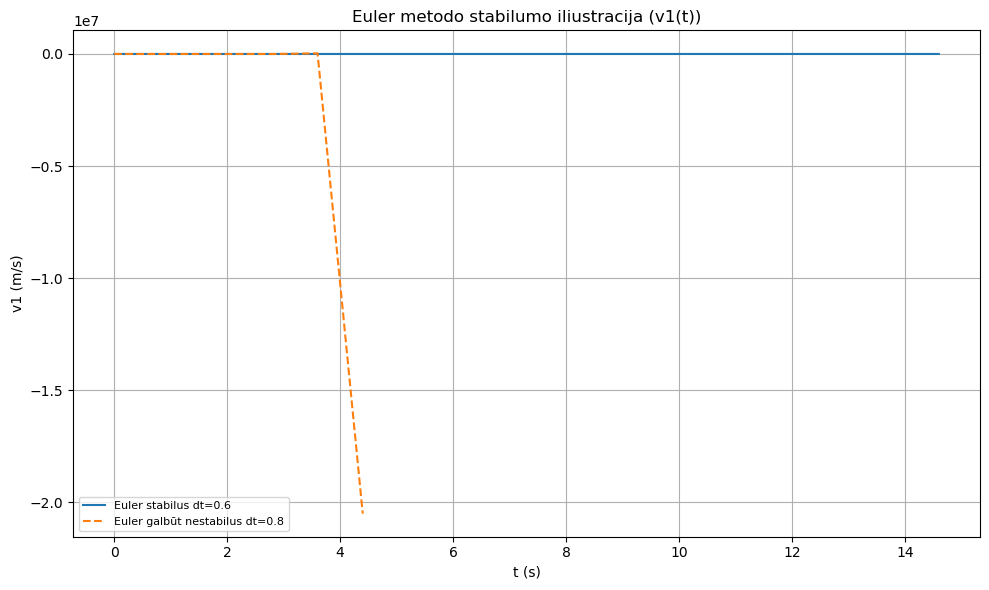

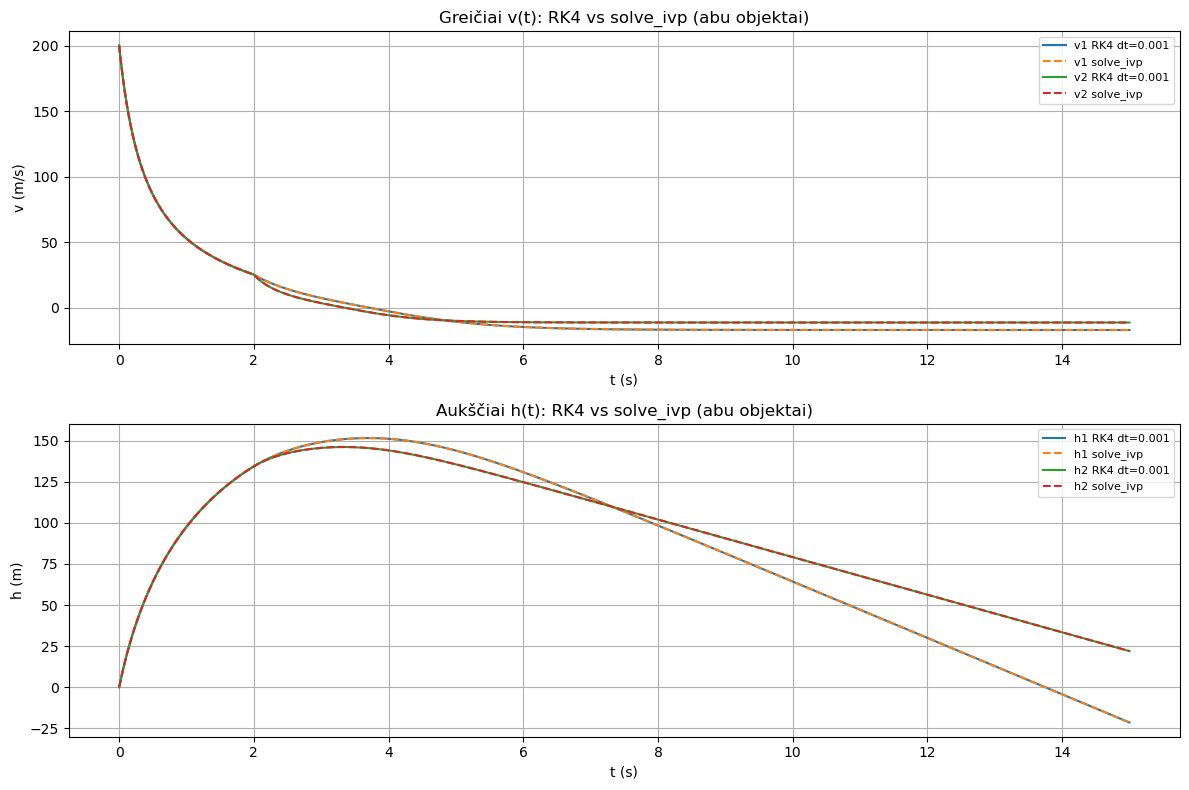

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g = 9.81     # m/s^2
m1 = 0.6     # kg
m2 = 0.2     # kg
v0 = 200.0   # m/s - pradine vertikali greitis (aukštyn teigiamas)
ks = 0.01    # kg/m (sujungtiems kūnams)
ts = 2.0     # s - laikas, po kurio jie atskiriami
k1 = 0.02    # kg/m (1 objektui po atsiskyrimo)
k2 = 0.015   # kg/m (2 objektui po atsiskyrimo)
tmax = 15.0  # s - iki kada skaičiuojame

def accel(v, k, m):
    # |v| reikalingas oro pasipriešinimo modeliui
    v_abs = abs(v)
    # Jeigu greitis tampa absurdiškai didelis (dėl nestabilaus metodo),
    # geriau grąžinti NaN, kad sustabdytume skaičiavimus.
    if v_abs > 1e6:
        return np.nan

    # Pagreitis dv/dt sudarytas iš dviejų jėgų:
    #   1) gravitacija:      -g        (visada veikia žemyn)
    #   2) oro pasipriešinimas: -(k/m) * v * |v|
    # Galutinis pagreitis
    return -g - (k / m) * v * v_abs

def rk4_step(h, v, dt, k, m):
    # sistema: dh/dt = v; dv/dt = accel(v)
    # k1 (pradžios taške)
    k1_h = v
    k1_v = accel(v, k, m)
    # k2 (pusę žingsnio toliau)
    v2 = v + 0.5 * dt * k1_v
    k2_h = v + 0.5 * dt * k1_v
    k2_v = accel(v2, k, m)
    # k3 (vėl per pusę žingsnio)
    v3 = v + 0.5 * dt * k2_v
    k3_h = v + 0.5 * dt * k2_v
    k3_v = accel(v3, k, m)
    # k4 (žingsnio pabaigoje)
    v4 = v + dt * k3_v
    k4_h = v + dt * k3_v
    k4_v = accel(v4, k, m)
    # update (svorinis vidurkis)
    h_new = h + dt/6.0 * (k1_h + 2*k2_h + 2*k3_h + k4_h)
    v_new = v + dt/6.0 * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    return h_new, v_new

def euler_step(h, v, dt, k, m):
    # dh/dt = v  → aukščio pokytis yra tiesiog greitis
    dh = v
    dv = accel(v, k, m)
    # Euler metodas sako:
    #   nauja reikšmė = sena reikšmė + dt * išvestinė
    return h + dt * dh, v + dt * dv

def simulate_two_stage(method='RK4', dt=0.001):
    # laiko tinklelis fazei 1
    t_arr1 = np.arange(0.0, ts + 1e-12, dt)
    N1 = len(t_arr1)
    # pradinės sąlygos
    h = 0.0
    v = v0
    h_hist1 = np.zeros(N1)
    v_hist1 = np.zeros(N1)
    h_hist1[0] = h
    v_hist1[0] = v
    M = m1 + m2

    # 1 FAZĖ: abu kūnai sujungti į vieną (masė M = m1 + m2, pasipriešinimas ks)
    for i in range(N1-1):
        if method.upper() == 'RK4':
            h, v = rk4_step(h, v, dt, ks, M)
        else:
            h, v = euler_step(h, v, dt, ks, M)

        # Stabilumo patikra: jeigu skaičiai pavirto NaN/inf → laikome, kad sprendinys subyrėjo
        if (not np.isfinite(h)) or (not np.isfinite(v)):
            # užpildome likusią trajektorijos dalį NaN
            h_hist1[i+1:] = np.nan
            v_hist1[i+1:] = np.nan
            break

        # Išsaugome naujas reikšmes istorijoje
        h_hist1[i+1] = h
        v_hist1[i+1] = v

    # Fazės 1 pabaigos reikšmės (ties t = ts) – jos taps pradinėmis fazei 2
    h_ts = h_hist1[-1]
    v_ts = v_hist1[-1]

    # 2 FAZĖ: kūnai atsiskiria, ir toliau judame su skirtingomis masėmis
    # ir pasipriešinimo koeficientais
    t_arr2 = np.arange(ts + dt, tmax + 1e-12, dt)
    N2 = len(t_arr2)

    # Pilnas laiko masyvas: pirma fazė + antra fazė vienoje ašyje
    t_full = np.concatenate((t_arr1, t_arr2))
    h1 = np.zeros_like(t_full)
    v1 = np.zeros_like(t_full)
    h2 = np.zeros_like(t_full)
    v2 = np.zeros_like(t_full)

    # pirmos fazės kopija
    h1[:N1] = h_hist1
    v1[:N1] = v_hist1
    h2[:N1] = h_hist1
    v2[:N1] = v_hist1

    # Pradinės sąlygos fazei 2: abiejų objektų padėtis ir greitis tokie patys ties t = ts
    h1_cur = h_ts
    v1_cur = v_ts
    h2_cur = h_ts
    v2_cur = v_ts

    # Fazės 2 integravimas (nuo ts iki tmax) abiem objektams atskirai
    for j in range(N2):
        # Žingsnis kiekvienam objektui su atitinkamu k ir m
        if method.upper() == 'RK4':
            h1_cur, v1_cur = rk4_step(h1_cur, v1_cur, dt, k1, m1)
            h2_cur, v2_cur = rk4_step(h2_cur, v2_cur, dt, k2, m2)
        else:
            h1_cur, v1_cur = euler_step(h1_cur, v1_cur, dt, k1, m1)
            h2_cur, v2_cur = euler_step(h2_cur, v2_cur, dt, k2, m2)

        # Indeksas bendrame masyve (po fazės 1)
        idx = N1 + j

        # Jeigu bent vienam objektui atsirado NaN/inf → laikome, kad sprendinys nestabilus
        if (not np.isfinite(h1_cur)) or (not np.isfinite(v1_cur)) \
           or (not np.isfinite(h2_cur)) or (not np.isfinite(v2_cur)):
            h1[idx:] = np.nan
            v1[idx:] = np.nan
            h2[idx:] = np.nan
            v2[idx:] = np.nan
            break

        # Išsaugome naujas reikšmes bendruose masyvuose
        h1[idx] = h1_cur
        v1[idx] = v1_cur
        h2[idx] = h2_cur
        v2[idx] = v2_cur

    # Grąžiname pilną laiką ir abiejų objektų aukščius bei greičius
    return t_full, h1, h2, v1, v2

def find_peak_time_and_height(t, h, v):
    # Einame per visą greičio vektorių nuo antro elemento
    for i in range(1, len(t)):
        # Tikriname, ar greitis peržengė nulį
        if v[i-1] > 0 and v[i] <= 0:
            dv = v[i] - v[i-1]
            # Jei dv = 0, negalime interpoliuoti – tiesiog laikome viršūnę v[i-1] taške
            if dv == 0:
                frac = 0.0
            else:
                # Linijinės interpoliacijos koeficientas:
                # frac = dalis intervalo, kur greitis buvo lygus 0
                frac = -v[i-1] / dv
            t_peak = t[i-1] + frac * (t[i] - t[i-1])
            h_peak = h[i-1] + frac * (h[i] - h[i-1])
            # Grąžiname aukščiausio taško laiką ir aukštį
            return t_peak, h_peak
    return np.nan, np.nan

def simulate_two_stage_solve_ivp(max_step=0.001):
    # --- FAZĖ 1: sujungtas kūnas (bendra masė m1 + m2, pasipriešinimas ks) ---

    # Dešinė pusė sistemai:
    # y = [h, v], kur h - aukštis, v - greitis
    def rhs_combined(t, y):
        h, v = y
        return [v, accel(v, ks, m1 + m2)]

    # Sprendžiame fazę 1 nuo t=0 iki t=ts
    sol1 = solve_ivp(rhs_combined,
                     (0.0, ts),
                     (0.0, v0),
                     max_step=max_step,
                     rtol=1e-8, atol=1e-10)

    # Paimame fazės 1 pabaigos reikšmes (ties t = ts)
    h_ts_ivp = sol1.y[0, -1]
    v_ts_ivp = sol1.y[1, -1]

    # --- FAZĖ 2: du atskiri kūnai su skirtingomis m ir k ---

    # Dešinė pusė objektui 1 (m1, k1)
    def rhs_obj1(t, y):
        h, v = y
        return [v, accel(v, k1, m1)]

    # Dešinė pusė objektui 2 (m2, k2)
    def rhs_obj2(t, y):
        h, v = y
        return [v, accel(v, k2, m2)]

    # Sprendžiame objektą 1 nuo t=ts iki t=tmax su pradinėmis h(ts), v(ts)
    sol_obj1 = solve_ivp(rhs_obj1,
                         (ts, tmax),
                         (h_ts_ivp, v_ts_ivp),
                         max_step=max_step,
                         rtol=1e-8, atol=1e-10)

    # Sprendžiame objektą 2 nuo t=ts iki t=tmax su tomis pačiomis pradinėmis sąlygomis
    sol_obj2 = solve_ivp(rhs_obj2,
                         (ts, tmax),
                         (h_ts_ivp, v_ts_ivp),
                         max_step=max_step,
                         rtol=1e-8, atol=1e-10)

    # --- Sujungiame fazę 1 ir fazę 2 į vientisus masyvus kiekvienam objektui ---
    t1_ivp = np.concatenate((sol1.t, sol_obj1.t[1:]))
    h1_ivp = np.concatenate((sol1.y[0], sol_obj1.y[0, 1:]))
    v1_ivp = np.concatenate((sol1.y[1], sol_obj1.y[1, 1:]))

    t2_ivp = np.concatenate((sol1.t, sol_obj2.t[1:]))
    h2_ivp = np.concatenate((sol1.y[0], sol_obj2.y[0, 1:]))
    v2_ivp = np.concatenate((sol1.y[1], sol_obj2.y[1, 1:]))

    # Grąžiname etaloninius sprendinius abiem objektams
    return t1_ivp, h1_ivp, v1_ivp, t2_ivp, h2_ivp, v2_ivp

def did_not_blow_up(h, v, h_max=1e5, v_max=1e4):
    # Patikriname, ar trajektorijoje nėra neleistinų reikšmių (NaN, inf)
    if np.any(~np.isfinite(h)) or np.any(~np.isfinite(v)):
        return False
    # h arba v yra absurdiškai dideli
    if np.max(np.abs(h)) > h_max or np.max(np.abs(v)) > v_max:
        return False
    return True

def stability_factor(dt, v, k, m):
    # s = dt * |f'(v)|, kur f'(v)=-(2k/m)|v|
    return dt * (2.0 * k / m) * np.abs(v)

def simulate_two_stage_with_stability(method='Euler', dt=0.01):
    t, h1, h2, v1, v2 = simulate_two_stage(method=method, dt=dt)

    # stabilumo faktoriai:
    # fazė 1: sujungta masė (M, ks) galioja abiems iki ts
    M = m1 + m2
    # indeksai fazei 1 (t<=ts) ir fazei 2 (t>ts)
    mask1 = t <= ts + 1e-12
    mask2 = ~mask1

    s1_phase1 = stability_factor(dt, v1[mask1], ks, M)  # tas pats v1 ir v2 iki ts
    s2_phase1 = stability_factor(dt, v2[mask1], ks, M)

    # fazė 2: atskirai
    s1_phase2 = stability_factor(dt, v1[mask2], k1, m1)
    s2_phase2 = stability_factor(dt, v2[mask2], k2, m2)

    # max per visą laiką (pagal objektą)
    s1_max = np.nanmax(np.concatenate([s1_phase1, s1_phase2]))
    s2_max = np.nanmax(np.concatenate([s2_phase1, s2_phase2]))

    return t, h1, h2, v1, v2, s1_max, s2_max

def find_max_stable_step(method, dt_list):
    max_stable = None
    for dt in dt_list:
        # Funkcija grąžina laiką ir trajektorijas
        t, h1, h2, v1, v2 = simulate_two_stage(method=method, dt=dt)
        if did_not_blow_up(h1, v1) and did_not_blow_up(h2, v2):
            # Jei stabilu – įsimename šį dt kaip kol kas didžiausią stabilų žingsnį
            max_stable = dt
        else:
            # Jei bent vienas objektas nestabilus – break, nes didesni dt bus dar blogesni
            break
    return max_stable

if __name__ == "__main__":
    dt_list_phys = [0.1, 0.05, 0.02, 0.01, 0.005]

    # 0) RK4: v(t) abiem objektams su 5 skirtingais žingsniais (obj1 viršuje, obj2 apačioje)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    for dt in dt_list_phys:
        t_rk_dt, h1_rk_dt, h2_rk_dt, v1_rk_dt, v2_rk_dt = simulate_two_stage(method='RK4', dt=dt)
        ax1.plot(t_rk_dt, v1_rk_dt, label=f'dt={dt}')
        ax2.plot(t_rk_dt, v2_rk_dt, label=f'dt={dt}')
    
    ax1.set_title('Objektas 1, v1(t), RK4 su skirtingais žingsniais')
    ax1.set_ylabel('v1 (m/s)')
    ax1.grid()
    ax1.legend(fontsize=8)
    
    ax2.set_title('Objektas 2, v2(t), RK4 su skirtingais žingsniais')
    ax2.set_xlabel('t (s)')
    ax2.set_ylabel('v2 (m/s)')
    ax2.grid()
    ax2.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # 1) RK4: h(t) abiem objektams su 5 skirtingais žingsniais (obj1 viršuje, obj2 apačioje)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    for dt in dt_list_phys:
        t_rk_dt, h1_rk_dt, h2_rk_dt, v1_rk_dt, v2_rk_dt = simulate_two_stage(method='RK4', dt=dt)
        ax1.plot(t_rk_dt, h1_rk_dt, label=f'dt={dt}')
        ax2.plot(t_rk_dt, h2_rk_dt, label=f'dt={dt}')
    
    ax1.set_title('Objektas 1, h1(t), RK4 su skirtingais žingsniais')
    ax1.set_ylabel('h1 (m)')
    ax1.grid()
    ax1.legend(fontsize=8)
    
    ax2.set_title('Objektas 2, h2(t), RK4 su skirtingais žingsniais')
    ax2.set_xlabel('t (s)')
    ax2.set_ylabel('h2 (m)')
    ax2.grid()
    ax2.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # 2) Euler: v(t) abiem objektams su 5 skirtingais žingsniais (obj1 viršuje, obj2 apačioje)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    for dt in dt_list_phys:
        t_eu_dt, h1_eu_dt, h2_eu_dt, v1_eu_dt, v2_eu_dt = simulate_two_stage(method='Euler', dt=dt)
        ax1.plot(t_eu_dt, v1_eu_dt, label=f'dt={dt}')
        ax2.plot(t_eu_dt, v2_eu_dt, label=f'dt={dt}')
    
    ax1.set_title('Objektas 1, v1(t), Euler su skirtingais žingsniais')
    ax1.set_ylabel('v1 (m/s)')
    ax1.grid()
    ax1.legend(fontsize=8)
    
    ax2.set_title('Objektas 2, v2(t), Euler su skirtingais žingsniais')
    ax2.set_xlabel('t (s)')
    ax2.set_ylabel('v2 (m/s)')
    ax2.grid()
    ax2.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # 3) Euler: h(t) abiem objektams su 5 skirtingais žingsniais (obj1 viršuje, obj2 apačioje)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    for dt in dt_list_phys:
        t_eu_dt, h1_eu_dt, h2_eu_dt, v1_eu_dt, v2_eu_dt = simulate_two_stage(method='Euler', dt=dt)
        ax1.plot(t_eu_dt, h1_eu_dt, label=f'dt={dt}')
        ax2.plot(t_eu_dt, h2_eu_dt, label=f'dt={dt}')
    
    ax1.set_title('Objektas 1, h1(t), Euler su skirtingais žingsniais')
    ax1.set_ylabel('h1 (m)')
    ax1.grid()
    ax1.legend(fontsize=8)
    
    ax2.set_title('Objektas 2, h2(t), Euler su skirtingais žingsniais')
    ax2.set_xlabel('t (s)')
    ax2.set_ylabel('h2 (m)')
    ax2.grid()
    ax2.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # 1) Bazinė simuliacija ir aukščiausi taškai
    dt_base = 0.005

    t_rk, h1_rk, h2_rk, v1_rk, v2_rk = simulate_two_stage(method='RK4', dt=dt_base)
    t_eu, h1_eu, h2_eu, v1_eu, v2_eu = simulate_two_stage(method='Euler', dt=dt_base)

    t_peak1, h_peak1 = find_peak_time_and_height(t_rk, h1_rk, v1_rk)
    t_peak2, h_peak2 = find_peak_time_and_height(t_rk, h2_rk, v2_rk)

    print("== Aukščiausi taškai (RK4, dt = {:.4f}) ==".format(dt_base))
    print(f"Objektas 1: t = {t_peak1:.4f} s, h = {h_peak1:.4f} m")
    print(f"Objektas 2: t = {t_peak2:.4f} s, h = {h_peak2:.4f} m")

    t_peak1_eu, h_peak1_eu = find_peak_time_and_height(t_eu, h1_eu, v1_eu)
    t_peak2_eu, h_peak2_eu = find_peak_time_and_height(t_eu, h2_eu, v2_eu)
    
    print("\n== Aukščiausi taškai (Euler, dt = {:.4f}) ==".format(dt_base))
    print(f"Objektas 1: t = {t_peak1_eu:.4f} s, h = {h_peak1_eu:.4f} m")
    print(f"Objektas 2: t = {t_peak2_eu:.4f} s, h = {h_peak2_eu:.4f} m")

    # --- 1) Greičiai v1(t): RK4 vs Euler ---
    plt.figure(figsize=(10,5))
    plt.plot(t_rk, v1_rk, label='v1 RK4', linewidth=2)
    plt.plot(t_eu, v1_eu, label='v1 Euler', linewidth=2)
    plt.title('Greitis v1(t): RK4 vs Euler')
    plt.xlabel('t (s)')
    plt.ylabel('v1 (m/s)')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- 2) Greičiai v2(t): RK4 vs Euler ---
    plt.figure(figsize=(10,5))
    plt.plot(t_rk, v2_rk, label='v2 RK4', linewidth=2)
    plt.plot(t_eu, v2_eu, label='v2 Euler', linewidth=2)
    plt.title('Greitis v2(t): RK4 vs Euler')
    plt.xlabel('t (s)')
    plt.ylabel('v2 (m/s)')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- 3) Aukščiai h1(t): RK4 vs Euler ---
    plt.figure(figsize=(10,5))
    plt.plot(t_rk, h1_rk, label='h1 RK4', linewidth=2)
    plt.plot(t_eu, h1_eu, label='h1 Euler', linewidth=2)
    plt.title('Aukštis h1(t): RK4 vs Euler')
    plt.xlabel('t (s)')
    plt.ylabel('h1 (m)')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- 4) Aukščiai h2(t): RK4 vs Euler ---
    plt.figure(figsize=(10,5))
    plt.plot(t_rk, h2_rk, label='h2 RK4', linewidth=2)
    plt.plot(t_eu, h2_eu, label='h2 Euler', linewidth=2)
    plt.title('Aukštis h2(t): RK4 vs Euler')
    plt.xlabel('t (s)')
    plt.ylabel('h2 (m)')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3) Žingsnio įtakos tikslumui tyrimas (naudojame solve_ivp kaip "tikslų" sprendinį)
    t1_ivp, h1_ivp, v1_ivp, t2_ivp, h2_ivp, v2_ivp = simulate_two_stage_solve_ivp(max_step=0.0005)

    dt_list = dt_list_phys

    print("\n== Tikslumo palyginimas su solve_ivp (objektas 1, greitis v1) ==")
    print("{:>8s} {:>10s} {:>10s}".format("dt", "max|v_RK4-v_ivp|", "max|v_Eu-v_ivp|"))

    plt.figure(figsize=(10, 6))
    plt.plot(t1_ivp, v1_ivp, 'k', label='v1 solve_ivp (etalonas)')

    for dt in dt_list:
        t_rk_dt, h1_rk_dt, h2_rk_dt, v1_rk_dt, v2_rk_dt = simulate_two_stage(method='RK4', dt=dt)
        t_eu_dt, h1_eu_dt, h2_eu_dt, v1_eu_dt, v2_eu_dt = simulate_two_stage(method='Euler', dt=dt)

        v1_rk_interp = np.interp(t1_ivp, t_rk_dt, v1_rk_dt)
        v1_eu_interp = np.interp(t1_ivp, t_eu_dt, v1_eu_dt)

        err_rk = np.max(np.abs(v1_rk_interp - v1_ivp))
        err_eu = np.max(np.abs(v1_eu_interp - v1_ivp))

        print("{:8.4f} {:10.4e} {:10.4e}".format(dt, err_rk, err_eu))

        plt.plot(t_rk_dt, v1_rk_dt, label=f'RK4, dt={dt}')

    plt.title('RK4 konvergencija: v1(t) su skirtingais žingsniais ir solve_ivp')
    plt.xlabel('t (s)')
    plt.ylabel('v1 (m/s)')
    plt.grid()
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # 4) Metodų tikslumo palyginimas: paklaida vs dt
    rk_errors = []
    eu_errors = []
    for dt in dt_list:
        t_rk_dt, h1_rk_dt, h2_rk_dt, v1_rk_dt, v2_rk_dt = simulate_two_stage(method='RK4', dt=dt)
        t_eu_dt, h1_eu_dt, h2_eu_dt, v1_eu_dt, v2_eu_dt = simulate_two_stage(method='Euler', dt=dt)

        v1_rk_interp = np.interp(t1_ivp, t_rk_dt, v1_rk_dt)
        v1_eu_interp = np.interp(t1_ivp, t_eu_dt, v1_eu_dt)

        err_rk = np.max(np.abs(v1_rk_interp - v1_ivp))
        err_eu = np.max(np.abs(v1_eu_interp - v1_ivp))
        rk_errors.append(err_rk)
        eu_errors.append(err_eu)

    plt.figure(figsize=(8, 6))
    plt.loglog(dt_list, rk_errors, 'o-', label='RK4 paklaida')
    plt.loglog(dt_list, eu_errors, 's-', label='Euler paklaida')
    plt.gca().invert_xaxis()
    plt.xlabel('dt')
    plt.ylabel('max|v1 - v1_ivp|')
    plt.title('Metodų tikslumo palyginimas (objektas 1, v1)')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) Stabilumo tyrimas
    dt_stab_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5]

    max_stable_euler = find_max_stable_step('Euler', dt_stab_list)
    max_stable_rk4 = find_max_stable_step('RK4', dt_stab_list)

    print("\n== Stabilumo tyrimas (heuristinis) ==")
    print(f"Euler metodas: didžiausias stabilus dt ≈ {max_stable_euler}")
    print(f"RK4 metodas  : didžiausias stabilus dt ≈ {max_stable_rk4}")

    plt.figure(figsize=(10, 6))
    if max_stable_euler is not None:
        t_eu_st, h1_eu_st, h2_eu_st, v1_eu_st, v2_eu_st = simulate_two_stage('Euler', max_stable_euler)
        plt.plot(t_eu_st, v1_eu_st, label=f'Euler stabilus dt={max_stable_euler}')

        try:
            idx = dt_stab_list.index(max_stable_euler)
            if idx + 1 < len(dt_stab_list):
                dt_unst = dt_stab_list[idx + 1]
                t_eu_un, h1_eu_un, h2_eu_un, v1_eu_un, v2_eu_un = simulate_two_stage('Euler', dt_unst)
                plt.plot(t_eu_un, v1_eu_un, '--', label=f'Euler galbūt nestabilus dt={dt_unst}')
        except ValueError:
            pass

    plt.title('Euler metodo stabilumo iliustracija (v1(t))')
    plt.xlabel('t (s)')
    plt.ylabel('v1 (m/s)')
    plt.grid()
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # 6) Tiesioginis palyginimas su solve_ivp viename grafike (abu objektai)
    dt_small = 0.001
    t_rk_small, h1_rk_small, h2_rk_small, v1_rk_small, v2_rk_small = simulate_two_stage('RK4', dt_small)

    plt.figure(figsize=(12, 8))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_rk_small, v1_rk_small, label=f'v1 RK4 dt={dt_small}')
    ax1.plot(t1_ivp, v1_ivp, '--', label='v1 solve_ivp')
    ax1.plot(t_rk_small, v2_rk_small, label=f'v2 RK4 dt={dt_small}')
    ax1.plot(t2_ivp, v2_ivp, '--', label='v2 solve_ivp')
    ax1.set_title('Greičiai v(t): RK4 vs solve_ivp (abu objektai)')
    ax1.set_xlabel('t (s)')
    ax1.set_ylabel('v (m/s)')
    ax1.grid()
    ax1.legend(fontsize=8)

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(t_rk_small, h1_rk_small, label=f'h1 RK4 dt={dt_small}')
    ax2.plot(t1_ivp, h1_ivp, '--', label='h1 solve_ivp')
    ax2.plot(t_rk_small, h2_rk_small, label=f'h2 RK4 dt={dt_small}')
    ax2.plot(t2_ivp, h2_ivp, '--', label='h2 solve_ivp')
    ax2.set_title('Aukščiai h(t): RK4 vs solve_ivp (abu objektai)')
    ax2.set_xlabel('t (s)')
    ax2.set_ylabel('h (m)')
    ax2.grid()
    ax2.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
